# 4 CNN: Handwritten digits classification
<p>We'll implement a Convolutional Neural network (CNN) for hand-written digits classification, using MNIST images.</p>

<ul>
    <li><a href="#data">Data</a></li>
    <li><a href="#model">Model</a></li>
    <li><a href="#training">Training</a></li>
    <li><a href="#results">Results</a></li>
</ul>

In [1]:
# !pip install torchvision==0.9.1 torch==1.8.1 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [2]:
# Helper functions

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

In [3]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

In [4]:
def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [5]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## <a name="data" id="data">Data</a>

In [6]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [7]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [10]:
# Show the data type for each element in dataset - long
type(train_dataset[0][1])
# Each element in the rectangular tensor corresponds to a number 
# representing a pixel intensity as demonstrated by the following image.

int

label: 5


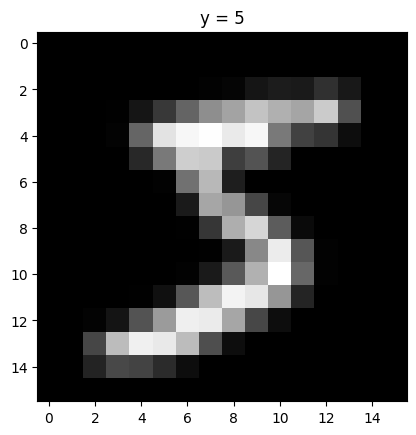

In [20]:
print("label: "+ str(train_dataset[0][1]))
show_data(train_dataset[0])

## <a name="model" id="model">Model</a>

In [ ]:
# Build a Convolutional Network class with two Convolutional layers 
# and one fully connected layer. 
# Pre-determine the size of the final output matrix. 
# The parameters in the constructor are the number of output channels for the 
# first and second layer.
class CNN(nn.Module):
    
    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each step
    def activations(self, x):
        #outputs activation - not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

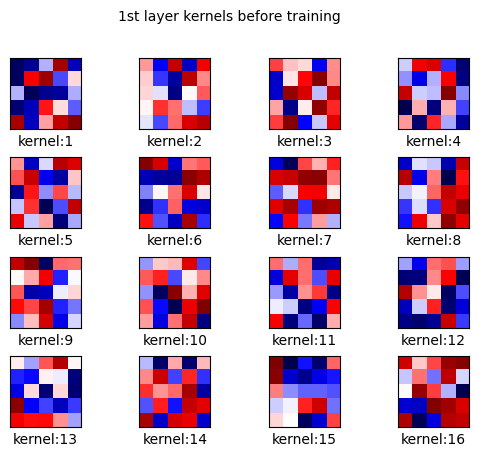

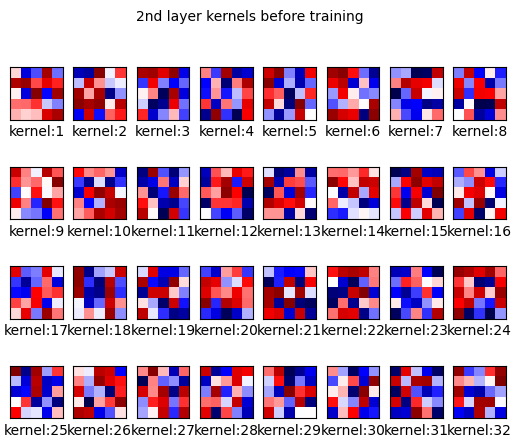

In [22]:
# Create the model object
model = CNN(out_1=16, out_2=32)

# Plot the parameters
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [23]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [24]:
model

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

## <a name="training" id="training">Training</a>

In [25]:
# Train the model

n_epochs = 3
cost_list = []
accuracy_list = []
N_test = len(validation_dataset)
COST = 0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST += loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

## <a name="results" id="results">Results</a>

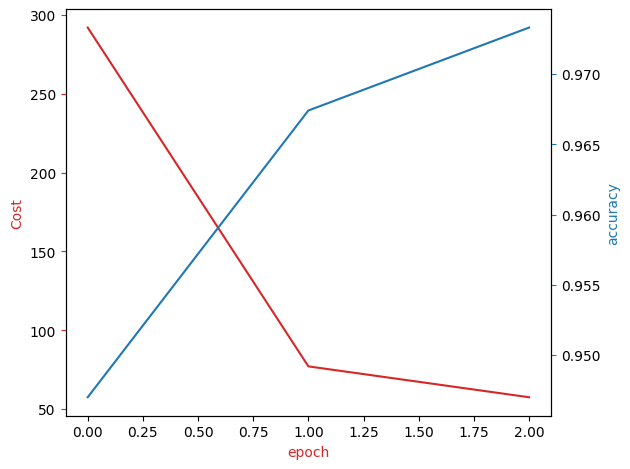

In [26]:
# Plot the loss and accuracy
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

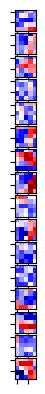

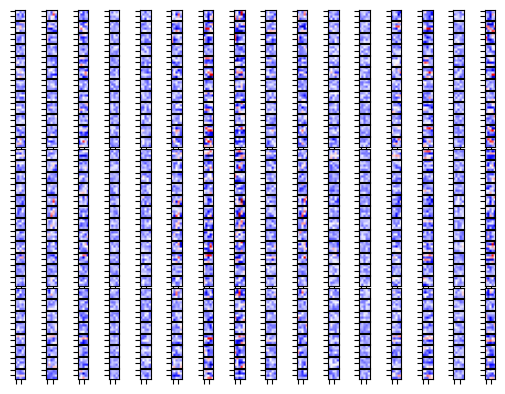

In [27]:
# Plot the channels
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

### Inspect activations

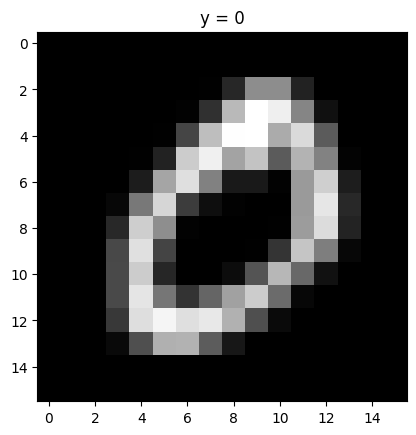

In [28]:
# Show the second image
show_data(train_dataset[1])

In [29]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

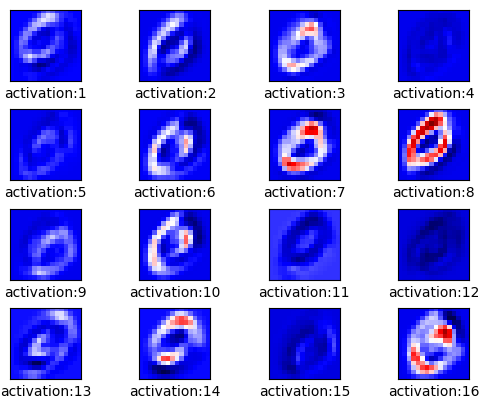

In [30]:
# Plot the outputs after the first CNN
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

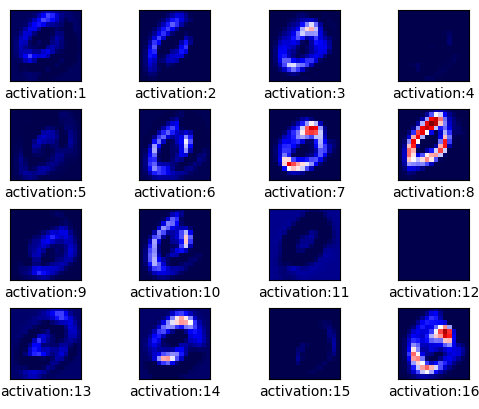

In [31]:
# Plot the outputs after the first Relu
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

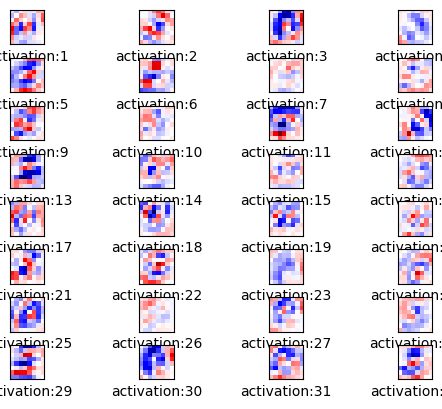

In [32]:
# Plot the outputs after the second CNN
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

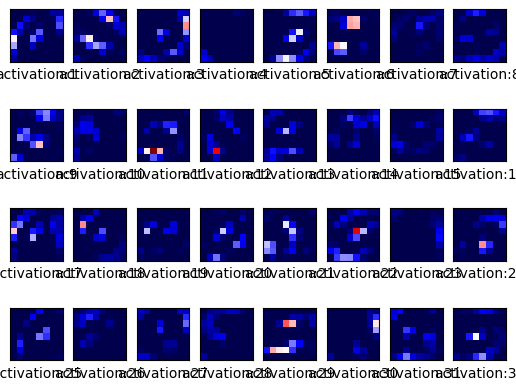

In [33]:
# Plot the outputs after the second Relu
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

### Misclassified samples

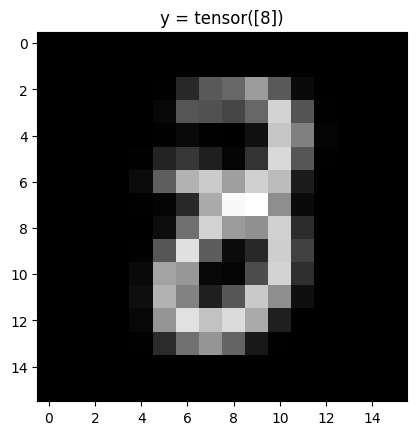

y_hat:  tensor([3])


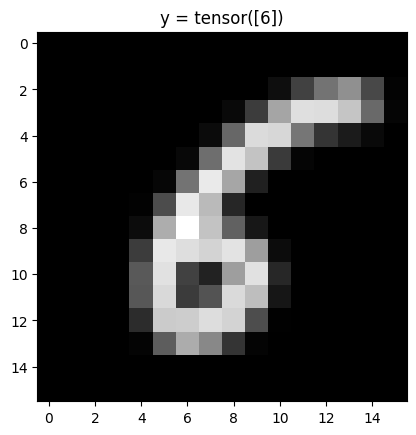

y_hat:  tensor([5])


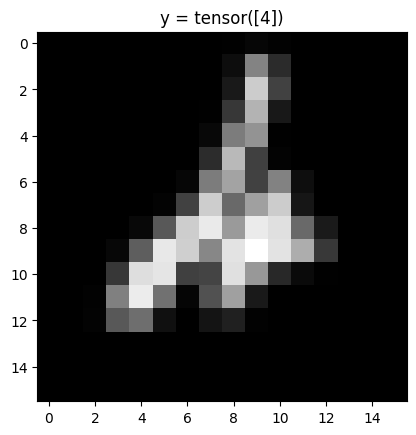

y_hat:  tensor([2])


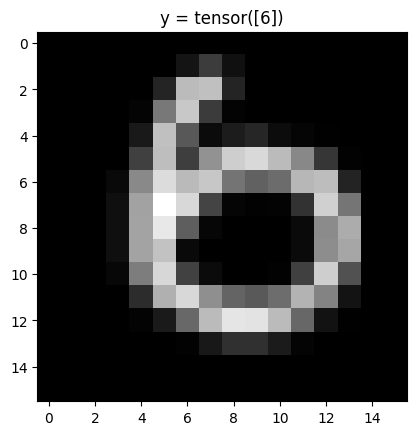

y_hat:  tensor([0])


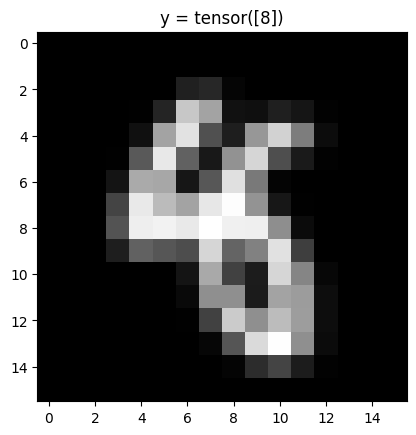

y_hat:  tensor([4])


In [39]:
# Plot the misclassified samples
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, y_hat = torch.max(z, 1)
    if y_hat != y:
        show_data((x, y))
        plt.show()
        print("y_hat: ",y_hat)
        count += 1
    if count >= 5:
        break  